In [1]:
#Importing packages for reading data
import os
os.chdir(r"C:\Users\colli\OneDrive\Documents\Parkinsons Project Regis")
import pandas as pd
import glob
import numpy as np

In [2]:
#Importing Relational Tables for training and test data
#source https://www.kaggle.com/code/dongkeunbak/pytorch-basic-starter-code-fog-with-lstm
#info about subjects with parkinson's
subjects = pd.read_csv('subjects.csv')
#outcome for subjects action in a lab or at home whether it caused a FOG event from Starting to walk, turning, or walking
events = pd.read_csv('events.csv')
#info for subjects action in a lab or at home that may have caused a FOG event
tasks = pd.read_csv('tasks.csv')
#Identifies each series in the defog dataset by a unique Subject, Visit, Medication condition.
meta = pd.read_csv('tdcsfog_metadata.csv')
#dataset, comprising data series collected in the subject's home, as subjects completed a FOG-provoking protocol
defog = pd.read_csv('defog_metadata.csv')
#Shows what a submission for the competition would look like
sub = pd.read_csv('sample_submission.csv')
#Final data to run your model against to predict if 1 of three FOG events occured for Start Hesitation, turning, or walking
test = glob.glob('test/**/**')

In [3]:
#function to read in the files
#source https://www.kaggle.com/code/dongkeunbak/pytorch-basic-starter-code-fog-with-lstm
def reader(f):
    df = pd.read_csv(f)
    df['Id'] = f.split('\\\\')[-1].split('.')[0]
    return df

In [4]:
# read train data
#source https://www.kaggle.com/code/dongkeunbak/pytorch-basic-starter-code-fog-with-lstm
test = pd.concat([reader(f) for f in test]).fillna(0); print(test.shape)
cols = [c for c in test.columns if c not in ['Id', 'StartHesitation', 'Turn' , 'Walking', 'Valid', 'Task','Event']] # except categorical and target fetaure

(286370, 5)


In [5]:
#looking at sujects data
subjects.head()

,Subject,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,04fcdb,1.0,63,M,3.0,30.0,NaN,0
1,05595e,1.0,56,M,8.0,28.0,NaN,0
2,0967b2,1.0,59,M,10.0,38.0,48.0,19
3,0967b2,2.0,59,M,10.0,37.0,44.0,13
4,097078,NaN,70,F,10.0,27.0,50.0,20


In [6]:
#checking for null values
subjects.isnull().sum()

Subject          0
Visit           62
Age              0
Sex              0
YearsSinceDx     0
UPDRSIII_On      1
UPDRSIII_Off    41
NFOGQ            0
dtype: int64

In [7]:
#importing visualization package
import seaborn as sns

C:\Users\colli\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sex', ylabel='count'>

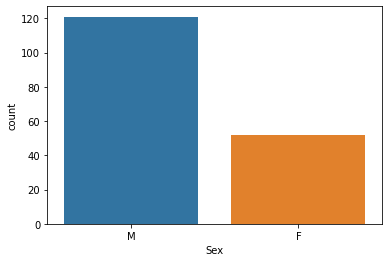

In [8]:
#EDA Subjects data for gender distibution
sns.countplot(subjects['Sex'])

<AxesSubplot:xlabel='Age', ylabel='Count'>

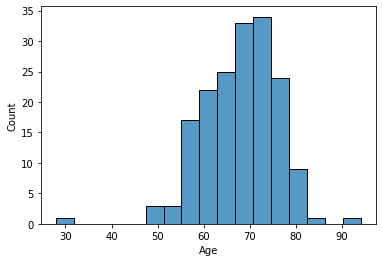

In [9]:
#EDA Subjects data for Age distribution
sns.histplot(subjects['Age'])

<AxesSubplot:xlabel='YearsSinceDx', ylabel='Count'>

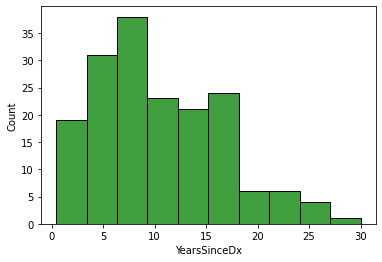

In [10]:
#Distribution for number of years that the patients have had parkinsons
sns.histplot(subjects['YearsSinceDx'], color = 'green')

<AxesSubplot:xlabel='UPDRSIII_On', ylabel='Count'>

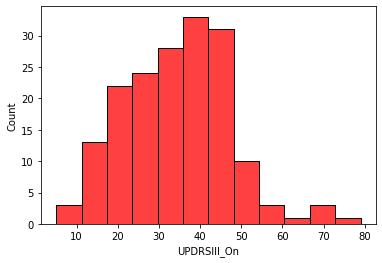

In [11]:
#Unified Parkinson's Disease Rating Scale score for each patient while on medication
sns.histplot(subjects['UPDRSIII_On'], color = 'red')

<AxesSubplot:xlabel='UPDRSIII_Off', ylabel='Count'>

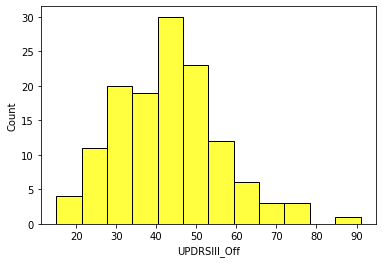

In [12]:
#Unified Parkinson's Disease Rating Scale score for each patient while off medication
sns.histplot(subjects['UPDRSIII_Off'], color = 'yellow')

In [13]:
#looking at tasks data
tasks.head()

,Id,Begin,End,Task
0,02ab235146,10.00,190.48,Rest1
1,02ab235146,211.24,271.56,Rest2
2,02ab235146,505.88,522.40,4MW
3,02ab235146,577.96,594.64,4MW-C
4,02ab235146,701.32,715.28,MB1


In [14]:
#checking for nulls in tasks data
tasks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2817 entries, 0 to 2816
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      2817 non-null   object 
 1   Begin   2817 non-null   float64
 2   End     2817 non-null   float64
 3   Task    2817 non-null   object 
dtypes: float64(2), object(2)
memory usage: 88.2+ KB


In [15]:
#checking the different types of tasks the subjects performed
tasks['Task'].unique()

array(['Rest1', 'Rest2', '4MW', '4MW-C', 'MB1', 'MB2a', 'MB2b', 'MB3-R',
       'MB3-L', 'MB4', 'MB5', 'MB6-R', 'MB6-L', 'MB7', 'MB8', 'MB9',
       'MB10', 'MB11', 'MB12', 'MB13', 'TUG-ST', 'TUG-DT', 'TUG-C',
       'Turning-ST', 'Turning-DT', 'Turning-C', 'Hotspot1', 'Hotspot1-C',
       'Hotspot2', 'Hotspot2-C', 'MB6'], dtype=object)

In [16]:
#Getting the time it took a patient to perform a task
tasks['Length'] = tasks['End'] - tasks['Begin']

In [17]:
tasks.head()

,Id,Begin,End,Task,Length
0,02ab235146,10.00,190.48,Rest1,180.48
1,02ab235146,211.24,271.56,Rest2,60.32
2,02ab235146,505.88,522.40,4MW,16.52
3,02ab235146,577.96,594.64,4MW-C,16.68
4,02ab235146,701.32,715.28,MB1,13.96


In [18]:
#Checking the average time each task takes a patient
tasks.groupby('Task')['Length'].mean()

Task
4MW            16.742168
4MW-C          18.444077
Hotspot1       19.805146
Hotspot1-C     19.661356
Hotspot2       57.677015
Hotspot2-C     57.270153
MB1             5.218015
MB10           12.152212
MB11           10.900179
MB12            7.263586
MB13            8.758779
MB2a            6.845810
MB2b            6.760318
MB3-L          13.335517
MB3-R          12.237815
MB4             3.902638
MB5             4.530712
MB6             4.023333
MB6-L           4.158355
MB6-R           4.162885
MB7            30.991477
MB8            21.458338
MB9            30.580231
Rest1         178.256378
Rest2          60.590000
TUG-C          19.021294
TUG-DT         22.462824
TUG-ST         16.011014
Turning-C      52.903918
Turning-DT     72.360219
Turning-ST     56.416672
Name: Length, dtype: float64

In [19]:
#Checking defog data
defog.head()

,Id,Subject,Visit,Medication
0,02ab235146,ab54e1,2,on
1,02ea782681,bf608b,2,on
2,06414383cf,c0b71e,2,off
3,092b4c1819,b6a627,1,off
4,0a900ed8a2,b7bd52,2,on


C:\Users\colli\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Visit', ylabel='count'>

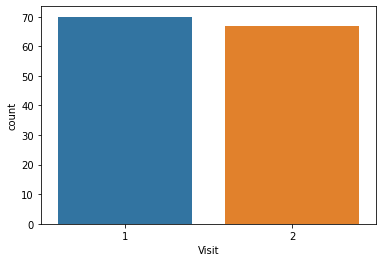

In [20]:
#checking the number of visits
sns.countplot(defog['Visit'])

C:\Users\colli\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Medication', ylabel='count'>

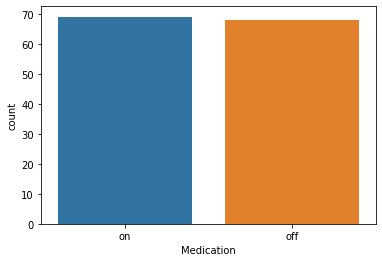

In [21]:
#Checking how many subjects were on or off medication
sns.countplot(defog['Medication'])

In [22]:
#Checking Meta dataset
meta.head()

,Id,Subject,Visit,Test,Medication
0,003f117e14,13abfd,3,2,on
1,009ee11563,d81e3a,4,2,on
2,011322847a,203e85,2,2,on
3,01d0fe7266,203e85,2,1,off
4,024418ba39,cecfb8,19,3,on


In [23]:
#Building a joined dataset to have subject information added to defog data where events were performed at home
join_df = pd.merge(defog, subjects, how='left', on='Subject').fillna(-1)

In [24]:
join_df.head()

,Id,Subject,Visit_x,Medication,Visit_y,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,02ab235146,ab54e1,2,on,1.0,79,F,8.0,52.0,55.0,28
1,02ab235146,ab54e1,2,on,2.0,79,F,8.0,38.0,64.0,28
2,02ea782681,bf608b,2,on,1.0,67,M,7.0,15.0,48.0,23
3,02ea782681,bf608b,2,on,2.0,67,M,7.0,14.0,57.0,19
4,06414383cf,c0b71e,2,off,1.0,61,F,7.0,45.0,52.0,22


In [25]:
#creating a 2nd dataset where events were performed in lab
join_df2 = pd.merge(meta, subjects, how='left', on='Subject').fillna(-1)

In [26]:
join_df2.head()

,Id,Subject,Visit_x,Test,Medication,Visit_y,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,003f117e14,13abfd,3,2,on,-1.0,68,F,9.0,17.0,15.0,15
1,009ee11563,d81e3a,4,2,on,-1.0,71,M,10.0,42.0,-1.0,24
2,011322847a,203e85,2,2,on,-1.0,67,M,12.0,27.0,28.0,19
3,01d0fe7266,203e85,2,1,off,-1.0,67,M,12.0,27.0,28.0,19
4,024418ba39,cecfb8,19,3,on,-1.0,60,F,7.0,30.0,-1.0,19


In [27]:
#Shrinking memory usage by changing datatype to smaller version
cols1 = ['Visit_x', 'YearsSinceDx','NFOGQ']
join_df[cols1] = join_df[cols1].astype('int8')

In [28]:
#Shrinking memory usage by changing datatype to smaller version
cols2 = ['Visit_y', 'YearsSinceDx','UPDRSIII_On','UPDRSIII_Off']
join_df[cols2] = join_df[cols2].astype('float16')

In [29]:
#Shrinking memory usage by changing datatype to smaller version
join_df2[cols1] = join_df2[cols1].astype('int8')
join_df2[cols2] = join_df2[cols2].astype('float16')

In [30]:
join_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            250 non-null    object 
 1   Subject       250 non-null    object 
 2   Visit_x       250 non-null    int8   
 3   Medication    250 non-null    object 
 4   Visit_y       250 non-null    float16
 5   Age           250 non-null    int64  
 6   Sex           250 non-null    object 
 7   YearsSinceDx  250 non-null    float16
 8   UPDRSIII_On   250 non-null    float16
 9   UPDRSIII_Off  250 non-null    float16
 10  NFOGQ         250 non-null    int8   
dtypes: float16(4), int64(1), int8(2), object(4)
memory usage: 14.2+ KB


In [31]:
events.head()

,Id,Init,Completion,Type,Kinetic
0,003f117e14,8.61312,14.7731,Turn,1.0
1,009ee11563,11.38470,41.1847,Turn,1.0
2,009ee11563,54.66470,58.7847,Turn,1.0
3,011322847a,28.09660,30.2966,Turn,1.0
4,01d0fe7266,30.31840,31.8784,Turn,1.0


In [32]:
#Adding events to at home dataset
join_df3 = pd.merge(join_df, events, how='left', on='Id').fillna(-1)

In [33]:
join_df3.head()

,Id,Subject,Visit_x,Medication,Visit_y,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ,Init,Completion,Type,Kinetic
0,02ab235146,ab54e1,2,on,1.0,79,F,8.0,52.0,55.0,28,1969.173,1972.535,-1,-1.0
1,02ab235146,ab54e1,2,on,1.0,79,F,8.0,52.0,55.0,28,2078.982,2080.524,-1,-1.0
2,02ab235146,ab54e1,2,on,1.0,79,F,8.0,52.0,55.0,28,2290.606,2291.952,-1,-1.0
3,02ab235146,ab54e1,2,on,1.0,79,F,8.0,52.0,55.0,28,2704.292,2704.770,-1,-1.0
4,02ab235146,ab54e1,2,on,1.0,79,F,8.0,52.0,55.0,28,2785.534,2785.774,-1,-1.0


In [34]:
#adding events to at lab dataset
join_df4 = pd.merge(join_df2, events, how='left', on='Id').fillna(-1)

In [35]:
join_df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1627 entries, 0 to 1626
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            1627 non-null   object 
 1   Subject       1627 non-null   object 
 2   Visit_x       1627 non-null   int8   
 3   Test          1627 non-null   int64  
 4   Medication    1627 non-null   object 
 5   Visit_y       1627 non-null   float16
 6   Age           1627 non-null   int64  
 7   Sex           1627 non-null   object 
 8   YearsSinceDx  1627 non-null   float16
 9   UPDRSIII_On   1627 non-null   float16
 10  UPDRSIII_Off  1627 non-null   float16
 11  NFOGQ         1627 non-null   int8   
 12  Init          1627 non-null   float64
 13  Completion    1627 non-null   float64
 14  Type          1627 non-null   object 
 15  Kinetic       1627 non-null   float64
dtypes: float16(4), float64(3), int64(2), int8(2), object(5)
memory usage: 155.7+ KB


In [36]:
#Getting rid of duplicate info between joined datasets
join_df3 = join_df3.drop(join_df3['Visit_y'])

In [37]:
join_df3.head()

,Id,Subject,Visit_x,Medication,Visit_y,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ,Init,Completion,Type,Kinetic
0,02ab235146,ab54e1,2,on,1.0,79,F,8.0,52.0,55.0,28,1969.173,1972.535,-1,-1.0
3,02ab235146,ab54e1,2,on,1.0,79,F,8.0,52.0,55.0,28,2704.292,2704.770,-1,-1.0
4,02ab235146,ab54e1,2,on,1.0,79,F,8.0,52.0,55.0,28,2785.534,2785.774,-1,-1.0
5,02ab235146,ab54e1,2,on,1.0,79,F,8.0,52.0,55.0,28,2785.786,2786.344,-1,-1.0
6,02ab235146,ab54e1,2,on,1.0,79,F,8.0,52.0,55.0,28,2827.264,2829.428,-1,-1.0


In [38]:
column_list = ['Id','Subject','Visit_x','Medication','Age','Sex','YearsSinceDx','UPDRSIII_On','UPDRSIII_Off','NFOGQ','Init','Completion','Type','Kinetic']

In [39]:
#Keeping only necessary columns
join_df4 = join_df4[column_list]

In [40]:
join_df4.head()

,Id,Subject,Visit_x,Medication,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ,Init,Completion,Type,Kinetic
0,003f117e14,13abfd,3,on,68,F,9.0,17.0,15.0,15,8.61312,14.7731,Turn,1.0
1,009ee11563,d81e3a,4,on,71,M,10.0,42.0,-1.0,24,11.38470,41.1847,Turn,1.0
2,009ee11563,d81e3a,4,on,71,M,10.0,42.0,-1.0,24,54.66470,58.7847,Turn,1.0
3,011322847a,203e85,2,on,67,M,12.0,27.0,28.0,19,28.09660,30.2966,Turn,1.0
4,01d0fe7266,203e85,2,off,67,M,12.0,27.0,28.0,19,30.31840,31.8784,Turn,1.0


In [41]:
#Keeping only necessary columns
cols2 = ['Init', 'Completion','Kinetic']
join_df3[cols2] = join_df3[cols2].astype('float16')
cols3 = ['Age']
join_df3[cols3] = join_df3[cols3].astype('int8')

In [42]:
#Shrinking memory usage by changing datatype to smaller version
cols2 = ['Init', 'Completion','Kinetic']
join_df4[cols2] = join_df4[cols2].astype('float16')
cols3 = ['Age']
join_df4[cols3] = join_df4[cols3].astype('int8')

In [43]:
#Shrinking memory usage by changing datatype to smaller version
join_df3['Type'] = join_df3['Type'].astype('category')

In [44]:
#Shrinking memory usage by changing datatype to smaller version
join_df4['Type'] = join_df4['Type'].astype('category')

In [45]:
join_df3["Type"] = np.where(join_df3["Type"] == -1, 'None', join_df3["Type"])

In [46]:
join_df4["Type"] = np.where(join_df4["Type"] == -1, 'None', join_df4["Type"])

C:\Users\colli\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Type', ylabel='count'>

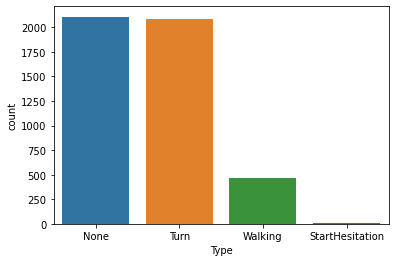

In [47]:
#Checking distribution of Dependent variable for at home dataset
sns.countplot(join_df3['Type'])

C:\Users\colli\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Type', ylabel='count'>

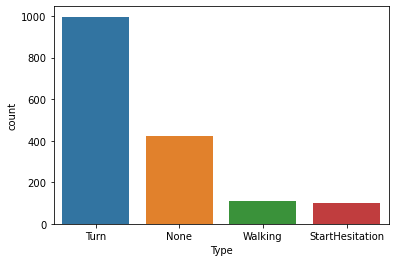

In [48]:
#Checking distribution of Dependent variable for at lab dataset, whether FOG was provoked from Walking, Turning, Starting to Walk, or no FOG event occured
sns.countplot(join_df4['Type'])

In [49]:
#Turning categorical into zeros and ones for model prediction
join_df3 = pd.get_dummies(join_df3
               ,columns = ['Type']
               )

In [50]:
#Turning categorical into zeros and ones for model prediction
join_df4 = pd.get_dummies(join_df4
               ,columns = ['Type']
               )

In [51]:
#Checking to make sure get_dummies worked
join_df3.head()

,Id,Subject,Visit_x,Medication,Visit_y,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ,Init,Completion,Kinetic,Type_None,Type_StartHesitation,Type_Turn,Type_Walking
0,02ab235146,ab54e1,2,on,1.0,79,F,8.0,52.0,55.0,28,1969.0,1973.0,-1.0,1,0,0,0
3,02ab235146,ab54e1,2,on,1.0,79,F,8.0,52.0,55.0,28,2704.0,2704.0,-1.0,1,0,0,0
4,02ab235146,ab54e1,2,on,1.0,79,F,8.0,52.0,55.0,28,2786.0,2786.0,-1.0,1,0,0,0
5,02ab235146,ab54e1,2,on,1.0,79,F,8.0,52.0,55.0,28,2786.0,2786.0,-1.0,1,0,0,0
6,02ab235146,ab54e1,2,on,1.0,79,F,8.0,52.0,55.0,28,2828.0,2830.0,-1.0,1,0,0,0


In [52]:
#Changing gender to numbers
join_df3['Sex'] = join_df3['Sex'].map({'F': 1, 'M': 0})

In [53]:
#Changing medication to numbers
join_df3['Medication'] = join_df4['Medication'].map({'on': 1, 'off': 0})

In [54]:
join_df4['Sex'] = join_df3['Sex'].map({'F': 1, 'M': 0})
join_df4['Medication'] = join_df4['Medication'].map({'on': 1, 'off': 0})

In [55]:
#combining at home and lab datasets to create final training set
all_dfs = [join_df3,join_df4]

In [56]:
#combining at home and lab datasets to create final training set
all_dfs_concat = pd.concat(all_dfs)

In [57]:
#combining at home and lab datasets to create final training set
all_dfs_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6291 entries, 0 to 1626
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    6291 non-null   object 
 1   Subject               6291 non-null   object 
 2   Visit_x               6291 non-null   int8   
 3   Medication            3252 non-null   float64
 4   Visit_y               4664 non-null   float16
 5   Age                   6291 non-null   int8   
 6   Sex                   4664 non-null   float64
 7   YearsSinceDx          6291 non-null   float16
 8   UPDRSIII_On           6291 non-null   float16
 9   UPDRSIII_Off          6291 non-null   float16
 10  NFOGQ                 6291 non-null   int8   
 11  Init                  6291 non-null   float16
 12  Completion            6291 non-null   float16
 13  Kinetic               6291 non-null   float16
 14  Type_None             6291 non-null   uint8  
 15  Type_StartHesitation 

In [58]:
#turning start and stop of event into duration of event for more meaningful value for the models
all_dfs_concat['Duration'] = all_dfs_concat['Completion'].sub(all_dfs_concat['Init'], axis = 0)

In [59]:
all_dfs_concat.head()

,Id,Subject,Visit_x,Medication,Visit_y,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ,Init,Completion,Kinetic,Type_None,Type_StartHesitation,Type_Turn,Type_Walking,Duration
0,02ab235146,ab54e1,2,1.0,1.0,79,1.0,8.0,52.0,55.0,28,1969.0,1973.0,-1.0,1,0,0,0,4.0
3,02ab235146,ab54e1,2,1.0,1.0,79,1.0,8.0,52.0,55.0,28,2704.0,2704.0,-1.0,1,0,0,0,0.0
4,02ab235146,ab54e1,2,0.0,1.0,79,1.0,8.0,52.0,55.0,28,2786.0,2786.0,-1.0,1,0,0,0,0.0
5,02ab235146,ab54e1,2,1.0,1.0,79,1.0,8.0,52.0,55.0,28,2786.0,2786.0,-1.0,1,0,0,0,0.0
6,02ab235146,ab54e1,2,1.0,1.0,79,1.0,8.0,52.0,55.0,28,2828.0,2830.0,-1.0,1,0,0,0,2.0


In [60]:
from sklearn.model_selection import train_test_split

In [61]:
#Defining Depent and independent variables for modeling
X = all_dfs_concat[['Age','YearsSinceDx','UPDRSIII_On','UPDRSIII_Off','NFOGQ','Init','Duration']]
ySH = all_dfs_concat['Type_StartHesitation']
yT = all_dfs_concat['Type_Turn']
yW = all_dfs_concat['Type_Walking']

In [62]:
#Splitting data into training and test
X_train, X_test, ySH_train, ySH_test = train_test_split(X, ySH, test_size = 0.3, random_state = 22)
X_train, X_test, yT_train, yT_test = train_test_split(X, yT, test_size = 0.3, random_state = 22)
X_train, X_test, yW_train, yW_test = train_test_split(X, yW, test_size = 0.3, random_state = 22)

In [63]:
#Scaling data
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

C:\Users\colli\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1746: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
C:\Users\colli\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1746: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)


In [64]:
#staring with basic Tree model
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
clfSH = DecisionTreeClassifier(criterion="entropy", max_depth=3)
clfT = DecisionTreeClassifier(criterion="entropy", max_depth=3)
clfW = DecisionTreeClassifier(criterion="entropy", max_depth=3)

In [65]:
#There are three dependent variables for this data whether each of three events triggered FOG, which is why three models are needed.  
#One to predict if Start Hesitation caused Freezing of Gait, one if turning caused FOG, and One if Walking caused Fog.
#Three models are consistent with the sample submission file from Kaggle where three predictions are needed in the output file.
clfSH.fit(X_train,ySH_train)
clfT.fit(X_train,yT_train)
clfW.fit(X_train,yW_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [66]:
#Predicting test set values
ySH_pred = clfSH.predict(X_test)
yT_pred = clfT.predict(X_test)
yW_pred = clfW.predict(X_test)

In [123]:
#Checking Results - Competition grades based off of precision
from sklearn.metrics import classification_report
print('StartHesitation:')
print(classification_report(ySH_test, ySH_pred))
print('Turning:')
print(classification_report(yT_test, yT_pred))
print('Walking:')
print(classification_report(yW_test, yW_pred))


StartHesitation:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1854
           1       0.00      0.00      0.00        34

    accuracy                           0.98      1888
   macro avg       0.49      0.50      0.50      1888
weighted avg       0.96      0.98      0.97      1888

Turning:
              precision    recall  f1-score   support

           0       1.00      0.21      0.35       948
           1       0.56      1.00      0.71       940

    accuracy                           0.60      1888
   macro avg       0.78      0.60      0.53      1888
weighted avg       0.78      0.60      0.53      1888

Walking:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1724
           1       0.00      0.00      0.00       164

    accuracy                           0.91      1888
   macro avg       0.46      0.50      0.48      1888
weighted avg       0.83      0.91      

C:\Users\colli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colli\anaconda3\lib\site-packages\sklearn\metr

In [68]:
#Tuning parameters for better performance from tree model
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth' : [2,3,4,5,6,7,8], 'min_samples_split' : [2,3,4], 'min_samples_leaf': [1,2]}

In [69]:
clfSH2 = DecisionTreeClassifier()
clfT2 = DecisionTreeClassifier()
clfW2 = DecisionTreeClassifier()



In [70]:
#creating gridsearch tree models
searchSH = GridSearchCV(estimator=clfSH2,param_grid = parameters)
searchT = GridSearchCV(estimator=clfT2,param_grid = parameters)
searchW = GridSearchCV(estimator=clfW2,param_grid = parameters)

In [71]:
#fitting models
searchSH.fit(X_train,ySH_train)
searchT.fit(X_train,yT_train)
searchW.fit(X_train,yW_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

In [72]:
#Fitting best parameters to the models
TreemodelSH = searchSH.best_estimator_
TreemodelSH.fit(X_train,ySH_train)

TreemodelT = searchT.best_estimator_
TreemodelT.fit(X_train,yT_train)

TreemodelW = searchW.best_estimator_
TreemodelW.fit(X_train,yW_train)

DecisionTreeClassifier(max_depth=7)

In [73]:
#predicting values for test data
ySH_pred2 = TreemodelSH.predict(X_test)
yT_pred2 = TreemodelT.predict(X_test)
yW_pred2 = TreemodelW.predict(X_test)

In [124]:
#Model Performed a little better after tuning especially for predicting the walking
from sklearn.metrics import classification_report
print('StartHesitation:')
print(classification_report(ySH_test, ySH_pred2))
print('Turning:')
print(classification_report(yT_test, yT_pred2))
print('Walking:')
print(classification_report(yW_test, yW_pred2))


StartHesitation:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1854
           1       0.00      0.00      0.00        34

    accuracy                           0.98      1888
   macro avg       0.49      0.50      0.50      1888
weighted avg       0.96      0.98      0.97      1888

Turning:
              precision    recall  f1-score   support

           0       0.64      0.83      0.72       948
           1       0.75      0.52      0.62       940

    accuracy                           0.68      1888
   macro avg       0.69      0.68      0.67      1888
weighted avg       0.69      0.68      0.67      1888

Walking:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1724
           1       0.66      0.27      0.38       164

    accuracy                           0.92      1888
   macro avg       0.80      0.63      0.67      1888
weighted avg       0.91      0.92      

C:\Users\colli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
#Trying Logistic regression model
from sklearn.linear_model import LogisticRegression
LogModelSH = LogisticRegression(solver='lbfgs', max_iter=1000)
LogModelT = LogisticRegression(solver='lbfgs', max_iter=1000)
LogModelW = LogisticRegression(solver='lbfgs', max_iter=1000)

LogModelSH.fit(X_train,ySH_train)
LogModelT.fit(X_train,yT_train)
LogModelW.fit(X_train,yW_train)

ySH_pred3 = LogModelSH.predict(X_test)
yT_pred3 = LogModelT.predict(X_test)
yW_pred3 = LogModelW.predict(X_test)

In [76]:
#Checking results, Logistic didn't perform better in any categories than the tree model
from sklearn.metrics import classification_report
print('StartHesitation:')
print(classification_report(ySH_test, ySH_pred3, zero_division=0))
print('Turning:')
print(classification_report(yT_test, yT_pred3, zero_division=0))
print('Walking:')
print(classification_report(yW_test, yW_pred3, zero_division=0))

StartHesitation:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1854
           1       0.00      0.00      0.00        34

    accuracy                           0.98      1888
   macro avg       0.49      0.50      0.50      1888
weighted avg       0.96      0.98      0.97      1888

Turning:
              precision    recall  f1-score   support

           0       0.55      0.62      0.58       948
           1       0.56      0.49      0.52       940

    accuracy                           0.55      1888
   macro avg       0.55      0.55      0.55      1888
weighted avg       0.55      0.55      0.55      1888

Walking:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1724
           1       0.00      0.00      0.00       164

    accuracy                           0.91      1888
   macro avg       0.46      0.50      0.48      1888
weighted avg       0.83      0.91      

In [77]:
#Trying support vector classification model
from sklearn.svm import SVC
SVCModelSH = SVC()
SVCModelT = SVC()
SVCModelW = SVC()

SVCModelSH.fit(X_train,ySH_train)
SVCModelT.fit(X_train,yT_train)
SVCModelW.fit(X_train,yW_train)

ySH_pred4 = LogModelSH.predict(X_test)
yT_pred4 = LogModelT.predict(X_test)
yW_pred4 = LogModelW.predict(X_test)

In [78]:
#Checking results, Tree model performed better in precision which is what the competition scores on
from sklearn.metrics import classification_report
print('StartHesitation:')
print(classification_report(ySH_test, ySH_pred4))
print('Turning:')
print(classification_report(yT_test, yT_pred4))
print('Walking:')
print(classification_report(yW_test, yW_pred4))

StartHesitation:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1854
           1       0.00      0.00      0.00        34

    accuracy                           0.98      1888
   macro avg       0.49      0.50      0.50      1888
weighted avg       0.96      0.98      0.97      1888

Turning:
              precision    recall  f1-score   support

           0       0.55      0.62      0.58       948
           1       0.56      0.49      0.52       940

    accuracy                           0.55      1888
   macro avg       0.55      0.55      0.55      1888
weighted avg       0.55      0.55      0.55      1888

Walking:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1724
           1       0.00      0.00      0.00       164

    accuracy                           0.91      1888
   macro avg       0.46      0.50      0.48      1888
weighted avg       0.83      0.91      

C:\Users\colli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colli\anaconda3\lib\site-packages\sklearn\metr

In [79]:
#Tuning parameters for better SVC performance
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
gridSH = GridSearchCV(SVC(), param_grid, refit = True)
gridT = GridSearchCV(SVC(), param_grid, refit = True)
gridW = GridSearchCV(SVC(), param_grid, refit = True)

In [80]:
#Fitting gridsearched SVC
gridSH.fit(X_train,ySH_train)
gridT.fit(X_train,yT_train)
gridW.fit(X_train,yW_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [81]:
#Showing best parameters
print(gridSH.best_params_)
print(gridSH.best_estimator_)
print(gridT.best_params_)
print(gridT.best_estimator_)
print(gridW.best_params_)
print(gridW.best_estimator_)


{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=0.1, gamma=1)
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, gamma=1)
{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1, gamma=1)


In [137]:
#Applying best parameters
gridSH1 = SVC(C = 1, gamma = 1, kernel = 'rbf')
gridT1 = SVC(C = 10, gamma = .1, kernel = 'rbf')
gridW1 = SVC(C = 10, gamma = .1, kernel = 'rbf')

In [138]:
#Fitting best parameters
gridSH1.fit(X_train,ySH_train)
gridT1.fit(X_train,yT_train)
gridW1.fit(X_train,yW_train)

SVC(C=10, gamma=0.1)

In [84]:
#Predicting best parameters
ySH_pred5 = gridSH1.predict(X_test)
yT_pred5 = gridT1.predict(X_test)
yW_pred5 = gridW1.predict(X_test)

In [85]:
#Viewing results, this model has best precision for walking
from sklearn.metrics import classification_report
print('StartHesitation:')
print(classification_report(ySH_test, ySH_pred5))
print('Turning:')
print(classification_report(yT_test, yT_pred5))
print('Walking:')
print(classification_report(yW_test, yW_pred5))

StartHesitation:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1854
           1       0.00      0.00      0.00        34

    accuracy                           0.98      1888
   macro avg       0.49      0.50      0.50      1888
weighted avg       0.96      0.98      0.97      1888

Turning:
              precision    recall  f1-score   support

           0       0.71      0.82      0.76       948
           1       0.79      0.66      0.72       940

    accuracy                           0.74      1888
   macro avg       0.75      0.74      0.74      1888
weighted avg       0.75      0.74      0.74      1888

Walking:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1724
           1       0.75      0.25      0.37       164

    accuracy                           0.93      1888
   macro avg       0.84      0.62      0.67      1888
weighted avg       0.92      0.93      

C:\Users\colli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
#importing oversampling package to balance out the precision better for 1's versus 0's 
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

In [87]:
#applying oversampling to dataset to help balance out the dependent variable classes
X_trainSH_OS, y_trainSH_OS = sm.fit_resample(X_train, ySH_train)
X_trainT_OS, y_trainT_OS = sm.fit_resample(X_train, yT_train)
X_trainW_OS, y_trainW_OS = sm.fit_resample(X_train, yW_train)

In [88]:
#trying optimized tree model with oversampled data
searchSH.fit(X_trainSH_OS, y_trainSH_OS)
searchT.fit(X_trainT_OS, y_trainT_OS)
searchW.fit(X_trainW_OS, y_trainW_OS)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

In [89]:
#applying best parameters
TreemodelSH_OS = searchSH.best_estimator_
TreemodelSH_OS.fit(X_trainSH_OS, y_trainSH_OS)

TreemodelT_OS = searchT.best_estimator_
TreemodelT_OS.fit(X_trainT_OS, y_trainT_OS)

TreemodelW_OS = searchW.best_estimator_
TreemodelW_OS.fit(X_trainW_OS, y_trainW_OS)

DecisionTreeClassifier(max_depth=8)

In [90]:
#Predicting using oversampling
ySH_OSpred = TreemodelSH_OS.predict(X_test)
yT_OSpred = TreemodelT_OS.predict(X_test)
yW_OSpred = TreemodelW_OS.predict(X_test)

In [91]:
from sklearn.metrics import classification_report
print('StartHesitation:')
print(classification_report(ySH_test, ySH_OSpred))
print('Turning:')
print(classification_report(yT_test, yT_OSpred))
print('Walking:')
print(classification_report(yW_test, yW_OSpred))

StartHesitation:
              precision    recall  f1-score   support

           0       0.99      0.56      0.71      1854
           1       0.03      0.76      0.06        34

    accuracy                           0.56      1888
   macro avg       0.51      0.66      0.39      1888
weighted avg       0.98      0.56      0.70      1888

Turning:
              precision    recall  f1-score   support

           0       0.64      0.83      0.72       948
           1       0.75      0.52      0.62       940

    accuracy                           0.68      1888
   macro avg       0.69      0.68      0.67      1888
weighted avg       0.69      0.68      0.67      1888

Walking:
              precision    recall  f1-score   support

           0       0.97      0.61      0.75      1724
           1       0.17      0.82      0.27       164

    accuracy                           0.62      1888
   macro avg       0.57      0.71      0.51      1888
weighted avg       0.90      0.62      

In [92]:
#Start Hesitation performs better with oversampling

In [93]:
#Logistic regression model with oversampling
LogModelSH.fit(X_trainSH_OS, y_trainSH_OS)
LogModelT.fit(X_trainT_OS, y_trainT_OS)
LogModelW.fit(X_trainW_OS, y_trainW_OS)

ySH_OSpred2 = LogModelSH.predict(X_test)
yT_OSpred2 = LogModelT.predict(X_test)
yW_OSpred2 = LogModelW.predict(X_test)

In [94]:
#Results, not much better than regular dataset logistic regression
from sklearn.metrics import classification_report
print('StartHesitation:')
print(classification_report(ySH_test, ySH_OSpred2))
print('Turning:')
print(classification_report(yT_test, yT_OSpred2))
print('Walking:')
print(classification_report(yW_test, yW_OSpred2))

StartHesitation:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      1854
           1       0.03      0.56      0.06        34

    accuracy                           0.66      1888
   macro avg       0.51      0.61      0.42      1888
weighted avg       0.97      0.66      0.78      1888

Turning:
              precision    recall  f1-score   support

           0       0.56      0.54      0.55       948
           1       0.55      0.56      0.56       940

    accuracy                           0.55      1888
   macro avg       0.55      0.55      0.55      1888
weighted avg       0.55      0.55      0.55      1888

Walking:
              precision    recall  f1-score   support

           0       0.92      0.45      0.60      1724
           1       0.09      0.60      0.16       164

    accuracy                           0.46      1888
   macro avg       0.51      0.53      0.38      1888
weighted avg       0.85      0.46      

In [139]:
gridSH2 = gridSH1
gridT2 = gridT1
gridW2 = gridW1

In [95]:
#SVC Oversampled model
gridSH2.fit(X_trainSH_OS, y_trainSH_OS)
gridT2.fit(X_trainT_OS, y_trainT_OS)
gridW2.fit(X_trainW_OS, y_trainW_OS)

SVC(C=10, gamma=0.1)

In [96]:
#SVC oversampled predictions
gridSHOSpred = gridSH2.predict(X_test)
gridTOSpred = gridT2.predict(X_test)
gridWOSpred = gridW2.predict(X_test)

In [97]:
#Results oversampled SVC, this has the best Starthesitation precision so far
from sklearn.metrics import classification_report
print('StartHesitation:')
print(classification_report(ySH_test, gridSHOSpred))
print('Turning:')
print(classification_report(yT_test, gridTOSpred))
print('Walking:')
print(classification_report(yW_test, gridWOSpred))

StartHesitation:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1854
           1       0.08      0.68      0.15        34

    accuracy                           0.86      1888
   macro avg       0.54      0.77      0.53      1888
weighted avg       0.98      0.86      0.91      1888

Turning:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       948
           1       0.73      0.76      0.75       940

    accuracy                           0.74      1888
   macro avg       0.74      0.74      0.74      1888
weighted avg       0.74      0.74      0.74      1888

Walking:
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      1724
           1       0.19      0.68      0.30       164

    accuracy                           0.73      1888
   macro avg       0.58      0.71      0.57      1888
weighted avg       0.89      0.73      

In [98]:
#xgboost install
pip install xgboost

In [126]:
#importing xgboost
import xgboost as xgb

In [100]:
#Creating XGBoost model
#https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390
xgbSH = xgb.XGBClassifier()
xgbT = xgb.XGBClassifier()
xgbW = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)

C:\Users\colli\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [101]:
#Fitting XGboost
xgbSH.fit(X_train,ySH_train)
xgbT.fit(X_train,ySH_train)
xgbW.fit(X_train,ySH_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [102]:
#predicting using xgboost
xgbSH_pred = xgbSH.predict(X_test)
xgbT_pred = xgbT.predict(X_test)
xgbW_pred = xgbW.predict(X_test)

In [103]:
#Results xgboost, did not perform great
from sklearn.metrics import classification_report
print('StartHesitation:')
print(classification_report(ySH_test, xgbSH_pred))
print('Turning:')
print(classification_report(yT_test, xgbT_pred))
print('Walking:')
print(classification_report(yW_test, xgbW_pred))

StartHesitation:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1854
           1       0.00      0.00      0.00        34

    accuracy                           0.98      1888
   macro avg       0.49      0.50      0.50      1888
weighted avg       0.96      0.98      0.97      1888

Turning:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       948
           1       0.00      0.00      0.00       940

    accuracy                           0.50      1888
   macro avg       0.25      0.50      0.33      1888
weighted avg       0.25      0.50      0.34      1888

Walking:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1724
           1       0.00      0.00      0.00       164

    accuracy                           0.91      1888
   macro avg       0.46      0.50      0.48      1888
weighted avg       0.83      0.91      

C:\Users\colli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colli\anaconda3\lib\site-packages\sklearn\metr

In [104]:
#XGboost oversampling
xgbSH.fit(X_trainSH_OS, y_trainSH_OS)
xgbT.fit(X_trainT_OS, y_trainT_OS)
xgbW.fit(X_trainW_OS, y_trainW_OS)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [105]:
#XGboost oversampling predictions
xgbSH_predOS = xgbSH.predict(X_test)
xgbT_predOS = xgbT.predict(X_test)
xgbW_predOS = xgbW.predict(X_test)

In [125]:
#XGboost oversampling predictions results,  precision does well for turning
from sklearn.metrics import classification_report
print('StartHesitation:')
print(classification_report(ySH_test, xgbSH_predOS))
print('Turning:')
print(classification_report(yT_test, xgbT_predOS))
print('Walking:')
print(classification_report(yW_test, xgbW_predOS))


StartHesitation:
              precision    recall  f1-score   support

           0       0.99      0.67      0.80      1854
           1       0.04      0.76      0.08        34

    accuracy                           0.67      1888
   macro avg       0.52      0.72      0.44      1888
weighted avg       0.98      0.67      0.79      1888

Turning:
              precision    recall  f1-score   support

           0       0.80      0.70      0.74       948
           1       0.73      0.82      0.77       940

    accuracy                           0.76      1888
   macro avg       0.76      0.76      0.76      1888
weighted avg       0.76      0.76      0.76      1888

Walking:
              precision    recall  f1-score   support

           0       0.98      0.41      0.58      1724
           1       0.13      0.92      0.23       164

    accuracy                           0.45      1888
   macro avg       0.56      0.66      0.40      1888
weighted avg       0.91      0.45      

In [107]:
#checking final test set to make submission off of
test.head()

,Time,AccV,AccML,AccAP,Id
0,0,-0.914652,-0.300851,0.298156,test\defog\02ab235146
1,1,-0.914367,-0.301572,0.298325,test\defog\02ab235146
2,2,-0.779540,-0.343197,0.275690,test\defog\02ab235146
3,3,-0.993162,-0.270281,0.315775,test\defog\02ab235146
4,4,-0.948767,-0.307849,0.297191,test\defog\02ab235146


In [108]:
#adjusting ID's to be able to join off of them
test['Id'] = test['Id'].str[-10:]

In [109]:
#joining for subject id, a majority of rows come from defog dataset patients
test_join = pd.merge(test, defog, how='left', on='Id')

In [110]:
test_join.head()

,Time,AccV,AccML,AccAP,Id,Subject,Visit,Medication
0,0,-0.914652,-0.300851,0.298156,02ab235146,ab54e1,2.0,on
1,1,-0.914367,-0.301572,0.298325,02ab235146,ab54e1,2.0,on
2,2,-0.779540,-0.343197,0.275690,02ab235146,ab54e1,2.0,on
3,3,-0.993162,-0.270281,0.315775,02ab235146,ab54e1,2.0,on
4,4,-0.948767,-0.307849,0.297191,02ab235146,ab54e1,2.0,on


In [111]:
#joining meta dataset, a small amount of subjects in final test set come from meta dataset
final_test = test_join.merge(meta, on='Id', how='left')

In [112]:
final_test.tail()

,Time,AccV,AccML,AccAP,Id,Subject_x,Visit_x,Medication_x,Subject_y,Visit_y,Test,Medication_y
286365,4677,-9.351431,0.370047,-2.286318,003f117e14,NaN,NaN,NaN,13abfd,3.0,2.0,on
286366,4678,-9.341410,0.347721,-2.321991,003f117e14,NaN,NaN,NaN,13abfd,3.0,2.0,on
286367,4679,-9.350667,0.361341,-2.297158,003f117e14,NaN,NaN,NaN,13abfd,3.0,2.0,on
286368,4680,-9.343977,0.365726,-2.292650,003f117e14,NaN,NaN,NaN,13abfd,3.0,2.0,on
286369,4681,-9.348477,0.379439,-2.335422,003f117e14,NaN,NaN,NaN,13abfd,3.0,2.0,on


In [113]:
#Getting correct subjects into one column
final_test['Subject_x'] = final_test['Subject_x'].mask(final_test['Subject_x'].isna(), final_test['Subject_y'])

In [114]:
#making sure subjects aren't missing
final_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286370 entries, 0 to 286369
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Time          286370 non-null  int64  
 1   AccV          286370 non-null  float64
 2   AccML         286370 non-null  float64
 3   AccAP         286370 non-null  float64
 4   Id            286370 non-null  object 
 5   Subject_x     286370 non-null  object 
 6   Visit_x       281688 non-null  float64
 7   Medication_x  281688 non-null  object 
 8   Subject_y     4682 non-null    object 
 9   Visit_y       4682 non-null    float64
 10  Test          4682 non-null    float64
 11  Medication_y  4682 non-null    object 
dtypes: float64(6), int64(1), object(5)
memory usage: 28.4+ MB


In [115]:
#Getting rid of unecessary columns
final_test = final_test.drop(['Visit_x', 'Medication_x', 'Subject_y', 'Visit_y', 'Test', 'Medication_y'], axis=1)

In [116]:
final_test.head()

,Time,AccV,AccML,AccAP,Id,Subject_x
0,0,-0.914652,-0.300851,0.298156,02ab235146,ab54e1
1,1,-0.914367,-0.301572,0.298325,02ab235146,ab54e1
2,2,-0.779540,-0.343197,0.275690,02ab235146,ab54e1
3,3,-0.993162,-0.270281,0.315775,02ab235146,ab54e1
4,4,-0.948767,-0.307849,0.297191,02ab235146,ab54e1


In [117]:
#Getting events into final test set
final_test = pd.merge(final_test, events, how='left', on='Id').fillna(-1)

In [118]:
final_test.head()

,Time,AccV,AccML,AccAP,Id,Subject_x,Init,Completion,Type,Kinetic
0,0,-0.914652,-0.300851,0.298156,02ab235146,ab54e1,1969.173,1972.535,-1,-1.0
1,0,-0.914652,-0.300851,0.298156,02ab235146,ab54e1,2078.982,2080.524,-1,-1.0
2,0,-0.914652,-0.300851,0.298156,02ab235146,ab54e1,2290.606,2291.952,-1,-1.0
3,0,-0.914652,-0.300851,0.298156,02ab235146,ab54e1,2704.292,2704.770,-1,-1.0
4,0,-0.914652,-0.300851,0.298156,02ab235146,ab54e1,2785.534,2785.774,-1,-1.0


In [119]:
#renaming subject column
final_test.rename(columns = {'Subject_x': 'Subject'}, inplace = True)

In [120]:
#
final_test = pd.merge(final_test, subjects, how='left', on='Subject').fillna(-1)


In [121]:
final_test['Duration'] = final_test['Completion'].sub(final_test['Init'], axis = 0)

In [122]:
#creating final test independent data
X_Final = final_test[['Age','YearsSinceDx','UPDRSIII_On','UPDRSIII_Off','NFOGQ','Init','Duration']]

In [129]:
#Using SVC Oversampled model for final predictions for StartHesistation, this model performed the best for Starthesitation
Final_SHpredictions = gridSH2.predict(X_Final)

In [135]:
#Using basic tree model for final predictions for Turning, this model performed the best for Turning
Final_Tpredictions = clfT.predict(X_Final)

In [140]:
#Using Optimized SVC without oversampling, this model performed the best for Walking
Final_Wpredictions = gridW1.predict(X_Final)

In [142]:
#Preparing final output
Final_dfSH = pd.DataFrame(Final_SHpredictions, columns = ['StartHesitation'])

In [144]:
#Preparing final output
Final_dfT = pd.DataFrame(Final_Tpredictions, columns = ['Turn'])

In [145]:
#Preparing final output
Final_dfW = pd.DataFrame(Final_Wpredictions , columns = ['Walking'])

In [173]:
#Preparing final output
Final_df = pd.concat([final_test['Id'],Final_dfSH,Final_dfT,Final_dfW],axis=1)

In [174]:
#Checking final output
Final_df.head()

,Id,StartHesitation,Turn,Walking
0,02ab235146,0,0,0
1,02ab235146,0,0,0
2,02ab235146,0,0,0
3,02ab235146,0,0,0
4,02ab235146,0,0,0


In [175]:
Final_df.to_csv('Submission.CSV')